In [4]:
# standard 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(41)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [5]:
nfl = pd.read_csv('./data/nfl_7mva.csv', index_col = 'schedule_date')

In [6]:
nfl.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
# rows = 7 years data, 32 teams, 16 games, - 7 weeks for each team = - 224 rows = 3360
nfl.shape

(3360, 25)

In [8]:
nfl.columns

Index(['id', 'schedule_season', 'schedule_week', 'target_team', 'score',
       'opponent_score', 'opponent_team', 'win_margin', 'passing_yards',
       'rushing_yards', 'opp_passing_yards', 'opp_rushing_yards', 'home_team',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'game_number',
       'home_yes', 'pf_7mva', 'pa_7mva', 'margin_7mva', 'pyards_7mva',
       'ryards_7mva', 'opp_pyards_7mva', 'opp_ryards_7mva'],
      dtype='object')

#### Target is target team's score
#### Features are all the moving average columns and home_yes

In [9]:
X = nfl[['home_yes', 'pf_7mva', 'pa_7mva','margin_7mva', 'pyards_7mva',
       'ryards_7mva', 'opp_pyards_7mva', 'opp_ryards_7mva']]
y= nfl['score'] # 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

### Set up Baseline where we just use the 7 week moving average of the score

In [11]:
baseline_preds = X_test['pf_7mva']

In [12]:
mean_absolute_error(y_test, baseline_preds)

8.11968537414966

#### Baseline MAE 8.05 

In [13]:
ss = StandardScaler()

In [14]:
X_train_scaled = ss.fit_transform(X_train, y_train)
X_test_scaled = ss.transform(X_test)

In [15]:
print(X_train_scaled.shape, X_test_scaled.shape)

(2688, 8) (672, 8)


### Linear Regression

In [16]:
lr = LinearRegression()

In [17]:
cross_val_score(lr, X_train_scaled, y_train)

array([0.14013124, 0.12420832, 0.15612483, 0.13871575, 0.14389711])

In [18]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [19]:
lr.score(X_train_scaled, y_train)

0.14367744980599406

In [20]:
lr.score(X_test_scaled, y_test)

0.12365255130931252

In [21]:
lr_preds = lr.predict(X_test_scaled)

In [22]:
mean_absolute_error(y_test, lr_preds)

7.450784648897537

#### Linear MAE: 7.38

In [23]:
lr.coef_

array([ 1.65003834e+00,  1.89249242e+15, -1.67226157e+15, -3.00858618e+15,
       -2.50954324e+00, -2.42851540e+00, -5.62316872e-02, -1.42277863e+00])

In [24]:
lr_coefs = pd.DataFrame(list(zip(X.columns, lr.coef_)))
lr_coefs_sorted = lr_coefs.sort_values(by = 1, ascending = False)
lr_coefs_sorted[1] = lr_coefs_sorted[1].round(decimals =1)
lr_coefs_sorted.rename(columns={0: 'Feature', 1: 'Coefficient'},inplace = True)
lr_coefs_sorted

,Feature,Coefficient
1,pf_7mva,1.892492e+15
0,home_yes,1.700000e+00
6,opp_pyards_7mva,-1.000000e-01
7,opp_ryards_7mva,-1.400000e+00
5,ryards_7mva,-2.400000e+00
4,pyards_7mva,-2.500000e+00
2,pa_7mva,-1.672262e+15
3,margin_7mva,-3.008586e+15


### Ridge

In [25]:
ridgecv = RidgeCV(alphas = (0.1, 1.0, 10, 100, 1000), store_cv_values=True)

In [26]:
ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        store_cv_values=True)

In [27]:
ridgecv.alpha_

10.0

In [28]:
ridgecv.score(X_train_scaled, y_train)

0.13577869828803268

In [29]:
ridgecv.score(X_test_scaled, y_test)

0.11738633661807873

In [30]:
ridgecv.coef_

array([ 1.83962498, -0.031232  , -2.61061319,  1.43141049, -2.66844121,
       -2.66882085, -0.0228276 , -1.81178758])

In [31]:
rpreds = ridgecv.predict(X_test_scaled)


In [32]:
resids = rpreds - y_test
resids_sq = (resids**2).sum()
act_mean = y_test.mean()
act_resids = y_test - act_mean
act_resids_sq = (act_resids **2).sum()
1 - resids_sq/act_resids_sq

0.11738633661807873

In [33]:
mean_absolute_error(y_test, rpreds)

7.4231387966943965

### MAE Ridge : 7.38

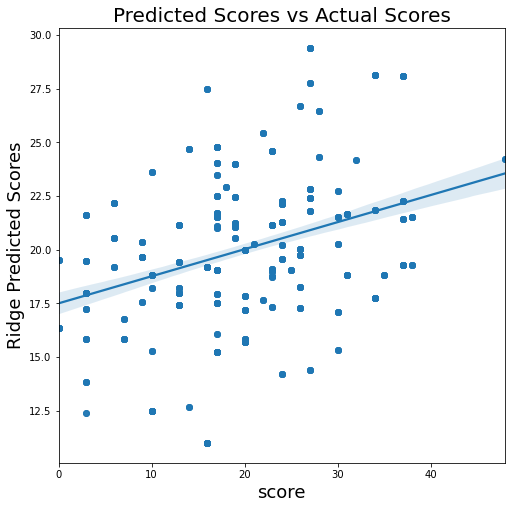

In [34]:
plt.figure(figsize = (8,8))
plt.title("Predicted Scores vs Actual Scores", fontsize=20)
plt.ylabel('Ridge Predicted Scores', fontsize=18)
plt.xlabel('Actual Scores', fontsize=18)
sns.regplot(y_test, rpreds);

In [35]:
r_coefs = pd.DataFrame(list(zip(X.columns, ridgecv.coef_)))
r_coefs_sorted = r_coefs.sort_values(by = 1, ascending = True)
r_coefs_sorted[1] = r_coefs_sorted[1].round(decimals =1)
r_coefs_sorted.rename(columns={0: 'Feature', 1: 'Coefficient'},inplace = True)
r_coefs_sorted

,Feature,Coefficient
5,ryards_7mva,-2.7
4,pyards_7mva,-2.7
2,pa_7mva,-2.6
7,opp_ryards_7mva,-1.8
1,pf_7mva,-0.0
6,opp_pyards_7mva,-0.0
3,margin_7mva,1.4
0,home_yes,1.8


In [36]:
def new_feat_lab(feature):
    new_label = {
        'pa_7mva': 'Opponent Points Scored 7MVA',
        'pf_7mva': 'Target Team Points Scored 7MVA',
        'pyards_7mva': 'Target Team Passing Yards 7MVA',
        'ryards_7mva': 'Target Team Rushing Yards 7MVA',
        'opp_pyards_7mva': 'Opponent Team Passing Yards 7MVA',
        'opp_ryards_7mva': 'Opponent Team Rushing Yards 7MVA',
        'margin_7mva' : 'Margin of Victory 7MVA',
        'home_yes' : 'Home Team Advantage'}
    return new_label[feature]

In [37]:
r_coefs_sorted['Feature'] = r_coefs_sorted['Feature'].apply(new_feat_lab)

In [38]:
r_coefs_sorted

,Feature,Coefficient
5,Target Team Rushing Yards 7MVA,-2.7
4,Target Team Passing Yards 7MVA,-2.7
2,Opponent Points Scored 7MVA,-2.6
7,Opponent Team Rushing Yards 7MVA,-1.8
1,Target Team Points Scored 7MVA,-0.0
6,Opponent Team Passing Yards 7MVA,-0.0
3,Margin of Victory 7MVA,1.4
0,Home Team Advantage,1.8


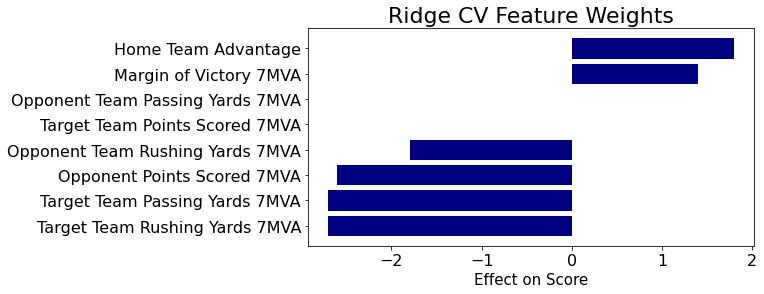

In [39]:
plt.figure(figsize = (8,4))
plt.barh(r_coefs_sorted['Feature'], r_coefs_sorted['Coefficient'], color='navy')
plt.title('Ridge CV Feature Weights', fontsize = 22)
plt.xlabel("Effect on Score",fontsize=15)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

### AdaBoost

In [40]:
boost = AdaBoostRegressor()

In [41]:
params = {'n_estimators': [100, 200, 500],
         'learning_rate': [10, 1.0, 0.1, 0.01, 0.05],
         'loss': ['linear', 'squared', 'exponential'] }

In [42]:
grid = GridSearchCV(boost, param_grid=params)

In [43]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [10, 1.0, 0.1, 0.01, 0.05],
                         'loss': ['linear', 'squared', 'exponential'],
                         'n_estimators': [100, 200, 500]})

In [44]:
grid.best_params_

{'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 200}

In [45]:
grid.score(X_train, y_train)

0.5397406864090002

In [46]:
grid.score(X_test, y_test)

0.5283153924508119

### Much better score

In [47]:
grid_preds = grid.predict(X_test)

In [48]:
mean_absolute_error(y_test, grid_preds)

5.548003741493413

In [49]:
best_boost = grid.best_estimator_

In [50]:
boost_df = pd.DataFrame({'features': X.columns, 'importance': best_boost.feature_importances_})

In [51]:
boost_feat = boost_df.sort_values('importance', ascending = True)
boost_feat

,features,importance
0,home_yes,0.024716
3,margin_7mva,0.074900
4,pyards_7mva,0.075899
7,opp_ryards_7mva,0.104696
5,ryards_7mva,0.140240
2,pa_7mva,0.174356
6,opp_pyards_7mva,0.202580
1,pf_7mva,0.202614


In [52]:
boost_feat['features'] = boost_feat['features'].apply(new_feat_lab)

In [53]:
boost_feat

,features,importance
0,Home Team Advantage,0.024716
3,Margin of Victory 7MVA,0.074900
4,Target Team Passing Yards 7MVA,0.075899
7,Opponent Team Rushing Yards 7MVA,0.104696
5,Target Team Rushing Yards 7MVA,0.140240
2,Opponent Points Scored 7MVA,0.174356
6,Opponent Team Passing Yards 7MVA,0.202580
1,Target Team Points Scored 7MVA,0.202614


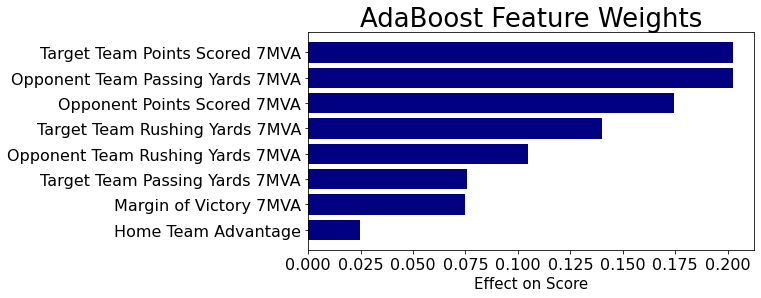

In [54]:
plt.figure(figsize = (8,4))
plt.barh(boost_feat['features'], boost_feat['importance'], color='navy')
plt.title('AdaBoost Feature Weights', fontsize = 26)
plt.xlabel("Effect on Score",fontsize=15)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

### Gradient Boosting

In [55]:
gboost = GradientBoostingRegressor()

In [56]:
params = {'loss': ['ls', 'huber'],
         'learning_rate': [0.05, 0.01, 0.4, 0.6], 
         'n_estimators': [10, 50, 75]}

In [57]:
boost_grid = GridSearchCV(gboost, param_grid=params)

In [58]:
boost_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.01, 0.4, 0.6],
                         'loss': ['ls', 'huber'],
                         'n_estimators': [10, 50, 75]})

In [59]:
boost_grid.best_params_

{'learning_rate': 0.6, 'loss': 'ls', 'n_estimators': 75}

In [60]:
boost_grid.score(X_train, y_train)

0.9999963907418588

In [61]:
boost_grid.score(X_test, y_test)


0.9999960227779507

- too many estimators; learning rate went up when lowered them. (as expected)

In [62]:
best_ada = grid.best_estimator_

In [63]:
ada_df = pd.DataFrame({'features': X.columns, 'importance': best_ada.feature_importances_})

In [64]:
ada_df.sort_values('importance', ascending = False)

,features,importance
1,pf_7mva,0.202614
6,opp_pyards_7mva,0.202580
2,pa_7mva,0.174356
5,ryards_7mva,0.140240
7,opp_ryards_7mva,0.104696
4,pyards_7mva,0.075899
3,margin_7mva,0.074900
0,home_yes,0.024716


### Sequential

In [96]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5)

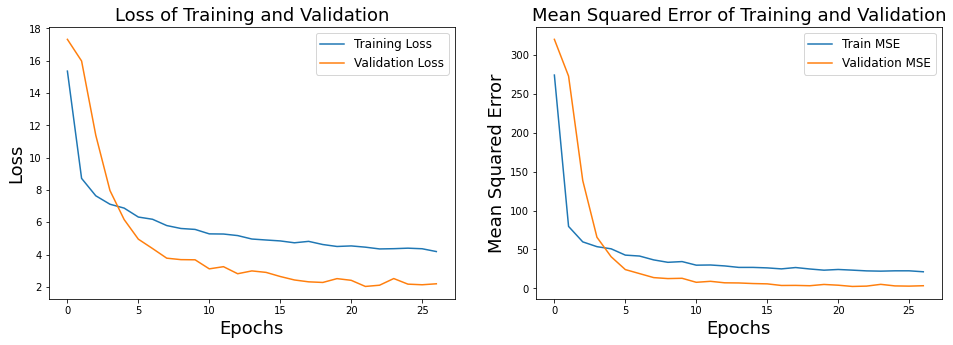

In [97]:
model_reg = Sequential()
model_reg.add(Input(shape=(8,)))
model_reg.add(BatchNormalization())
model_reg.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(0.05))
model_reg.add(BatchNormalization())
model_reg.add(Dense(128, activation= 'relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(0.05))
model_reg.add(BatchNormalization())
model_reg.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(.20))
model_reg.add(Dense(1))

# compile
model_reg.compile(loss='mae', 
                optimizer='adam', 
                metrics=['mse'])

# fit model with early stopping
history_reg = model_reg.fit(X_train, y_train, 
                         validation_data=(X_test, y_test), 
                         epochs=100,
                         verbose=0,
                         callbacks=[early_stop])

# plot
fig, ax = plt.subplots(1, 2, figsize=(16,5), linewidth= 20)

plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss');
plt.plot(history_reg.history['val_loss'], label='Validation Loss');
plt.legend(fontsize=12)
plt.title('Loss of Training and Validation',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18);


plt.subplot(1, 2, 2)
plt.plot(history_reg.history['mse'], label='Train MSE')
plt.plot(history_reg.history['val_mse'], label='Validation MSE')
plt.legend(fontsize=12)
plt.title('Mean Squared Error of Training and Validation', fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Mean Squared Error',fontsize=18);

### ANN MAE: 3.00

In [98]:
history_reg.history['loss'][-1]

4.18440055847168

In [99]:
mse = history_reg.history['mse'][-1]
mse ** .5

4.613822834160359

In [100]:
seq_preds = model_reg.predict(X_test)

In [101]:
mean_absolute_error(y_test, seq_preds)

1.4171548480434077

In [102]:
seq_preds[1][0]

8.729141

In [103]:
seq_preds[1]

array([8.729141], dtype=float32)

In [104]:
preds_list=[]
for i in seq_preds:
    #print(i[0])
    preds_list.append(i[0])

In [105]:
mean_absolute_error(y_test, preds_list)

1.4171548480434077

#### R squared

In [106]:
resids = preds_list - y_test
resids_sq = (resids**2).sum()
act_mean = y_test.mean()
act_resids = y_test - act_mean
act_resids_sq = (act_resids **2).sum()
1 - resids_sq/act_resids_sq

0.9641442816985853